<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2025-11-11 18:42:43--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2025-11-11 18:42:44--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2025-11-11 18:42:44 (52.0 MB/s) - ‘utils.py’ saved [2627/2627]



In [2]:
%run 'utils.py'

In [3]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [13]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

class HomeConvNet(nn.Module):
    """
    This class define the network architecture we must implement
    """

    def __init__(self):
        super(HomeConvNet, self).__init__()

        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # conv1
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # pool1
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), # conv2
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # pool2
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2), # conv3
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # pool3
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),  # fc4
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5),
            nn.Linear(1000, 10)           # fc5
        )

    def forward(self, x):
        bsize = x.size(0)
        x = self.features(x)
        x = x.view(bsize, -1)  # flatten
        x = self.classifier(x)
        return x


def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

def get_cifar_dataset(batch_size, cuda=False):
    """
    a new get_dataset to get the cifar10 dataset
    """
    mean = [0.491, 0.482, 0.447]
    deviation = [0.202, 0.199, 0.201]

    # Training transformations:
    train_transform = transforms.Compose([
        transforms.RandomCrop(28, padding=2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, deviation)
    ])

    # Test transformations
    test_transform = transforms.Compose([
        transforms.CenterCrop(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, deviation)
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    #model = ConvNet()
    model = HomeConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    #add a learning scheduler
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    #train, test = get_dataset(batch_size, cuda)
    train, test = get_cifar_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
        #modify the learning rate
        lr_scheduler.step()


=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 2.3036 (2.3036)	Prec@1   9.4 (  9.4)	Prec@5  51.6 ( 51.6)


<Figure size 640x480 with 0 Axes>

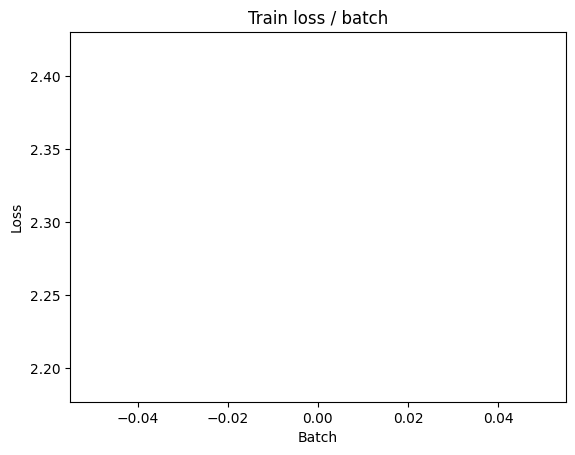

[TRAIN Batch 200/391]	Time 0.015s (0.045s)	Loss 1.9647 (2.0127)	Prec@1  28.9 ( 25.7)	Prec@5  83.6 ( 77.2)


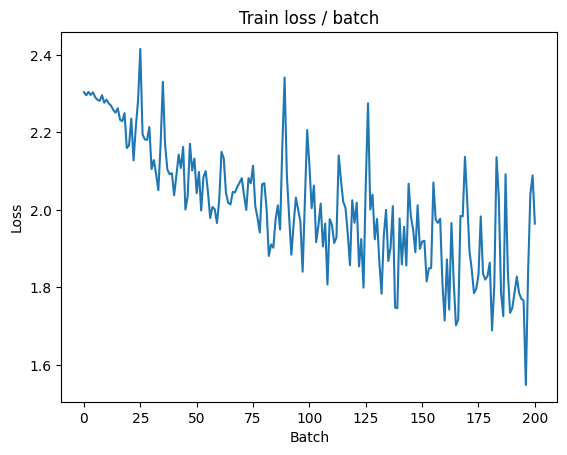


===============> Total time 16s	Avg loss 1.8640	Avg Prec@1 31.52 %	Avg Prec@5 82.46 %

[EVAL Batch 000/079]	Time 0.125s (0.125s)	Loss 1.5507 (1.5507)	Prec@1  46.1 ( 46.1)	Prec@5  91.4 ( 91.4)

===============> Total time 2s	Avg loss 1.5401	Avg Prec@1 43.79 %	Avg Prec@5 91.53 %



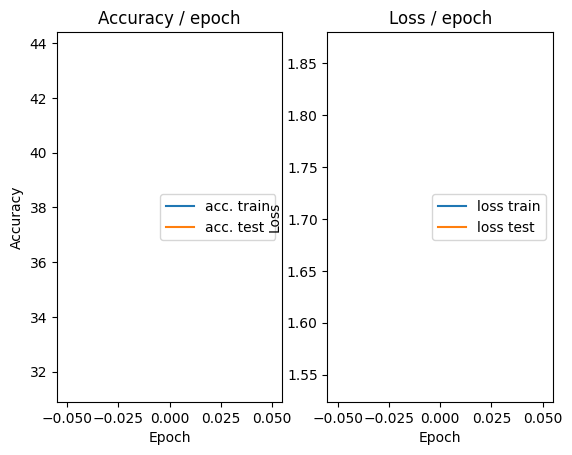

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.157s (0.157s)	Loss 1.6674 (1.6674)	Prec@1  42.2 ( 42.2)	Prec@5  90.6 ( 90.6)


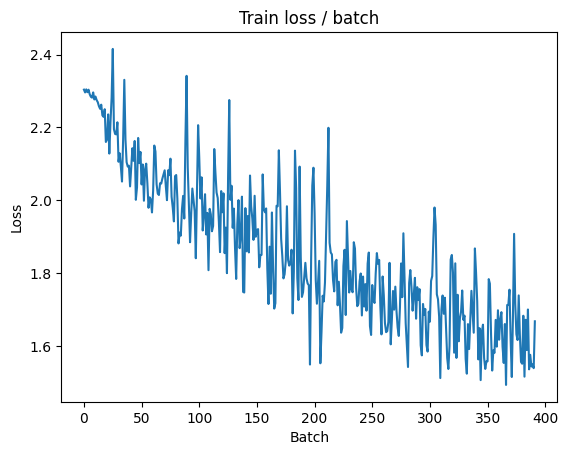

[TRAIN Batch 200/391]	Time 0.071s (0.045s)	Loss 1.7176 (1.5398)	Prec@1  38.3 ( 44.3)	Prec@5  85.9 ( 91.0)


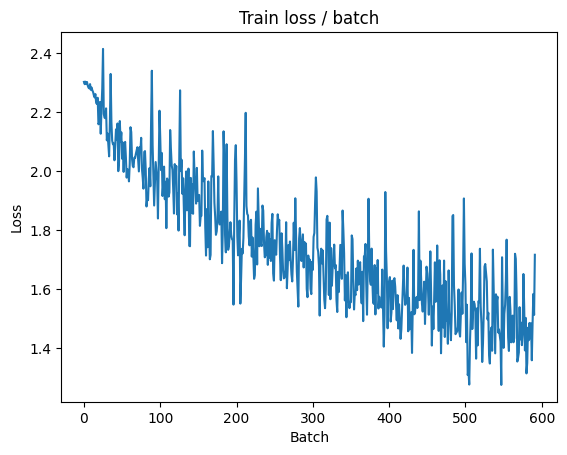


===============> Total time 17s	Avg loss 1.4928	Avg Prec@1 46.10 %	Avg Prec@5 91.73 %

[EVAL Batch 000/079]	Time 0.122s (0.122s)	Loss 1.2472 (1.2472)	Prec@1  55.5 ( 55.5)	Prec@5  93.0 ( 93.0)

===============> Total time 2s	Avg loss 1.2949	Avg Prec@1 51.74 %	Avg Prec@5 95.04 %



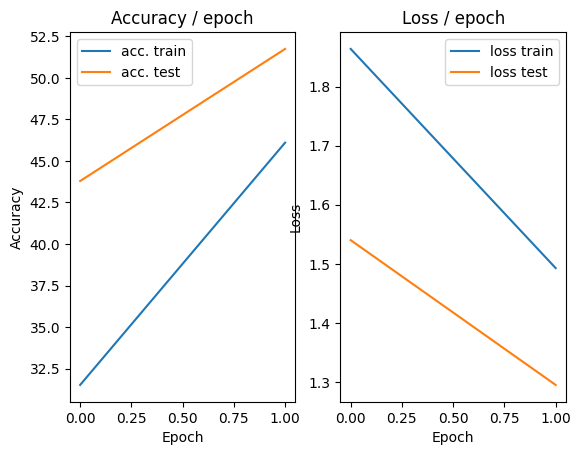

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 1.3586 (1.3586)	Prec@1  53.1 ( 53.1)	Prec@5  90.6 ( 90.6)


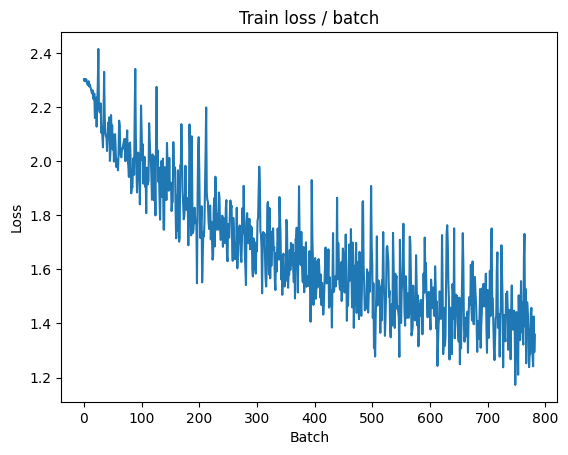

[TRAIN Batch 200/391]	Time 0.010s (0.044s)	Loss 1.3705 (1.3257)	Prec@1  48.4 ( 52.4)	Prec@5  90.6 ( 93.8)


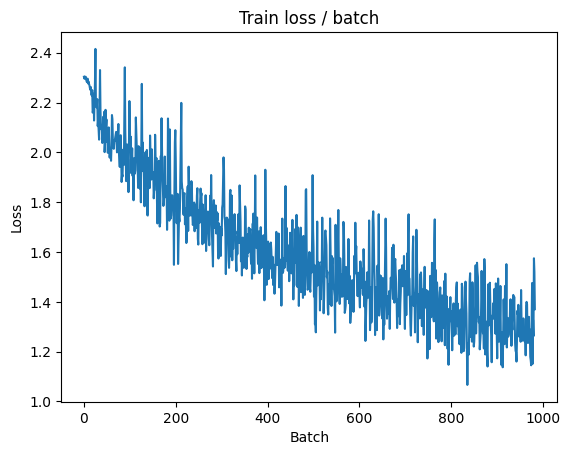


===============> Total time 16s	Avg loss 1.2938	Avg Prec@1 53.71 %	Avg Prec@5 94.23 %

[EVAL Batch 000/079]	Time 0.120s (0.120s)	Loss 1.2264 (1.2264)	Prec@1  57.8 ( 57.8)	Prec@5  94.5 ( 94.5)

===============> Total time 2s	Avg loss 1.1938	Avg Prec@1 57.76 %	Avg Prec@5 95.13 %



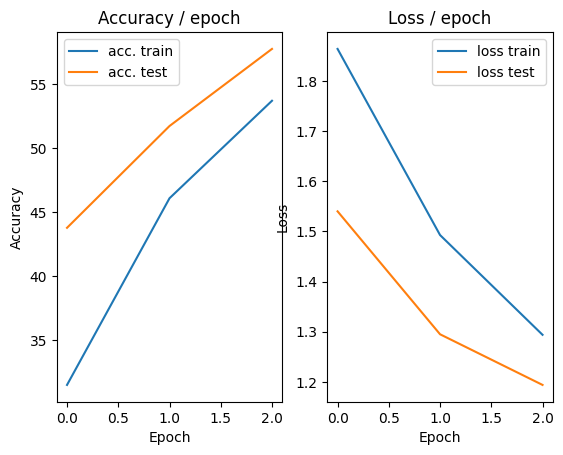

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.257s (0.257s)	Loss 1.1049 (1.1049)	Prec@1  58.6 ( 58.6)	Prec@5  96.9 ( 96.9)


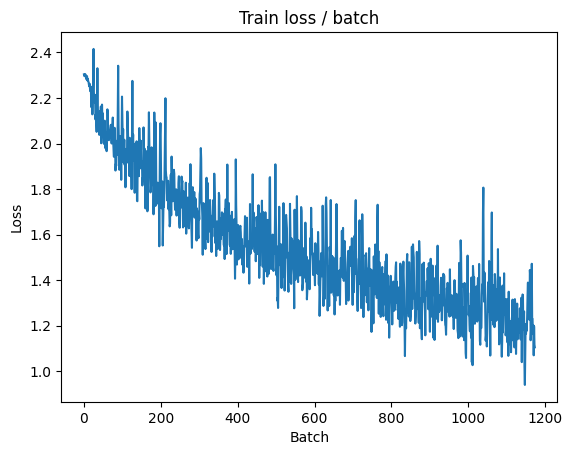

[TRAIN Batch 200/391]	Time 0.031s (0.042s)	Loss 0.9221 (1.1725)	Prec@1  67.2 ( 58.9)	Prec@5  96.9 ( 95.4)


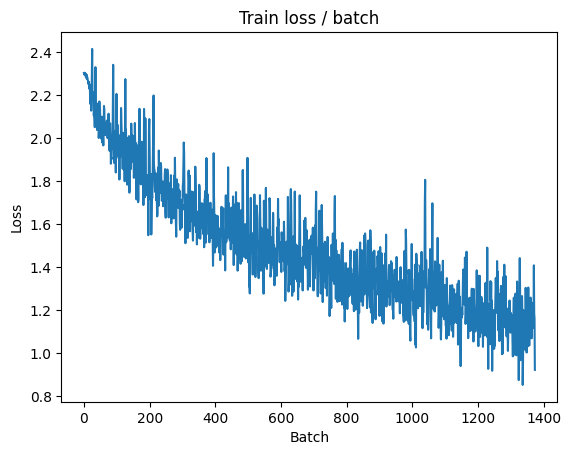


===============> Total time 16s	Avg loss 1.1475	Avg Prec@1 59.65 %	Avg Prec@5 95.55 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 1.0576 (1.0576)	Prec@1  65.6 ( 65.6)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.1474	Avg Prec@1 60.99 %	Avg Prec@5 95.63 %



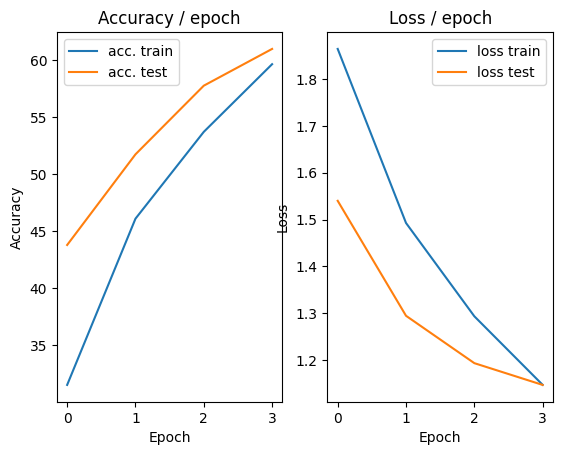

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.165s (0.165s)	Loss 1.1503 (1.1503)	Prec@1  60.2 ( 60.2)	Prec@5  96.9 ( 96.9)


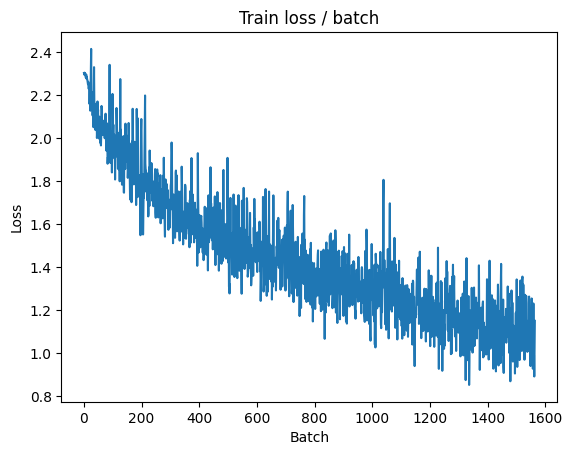

[TRAIN Batch 200/391]	Time 0.050s (0.045s)	Loss 1.0125 (1.0438)	Prec@1  62.5 ( 63.2)	Prec@5  98.4 ( 96.4)


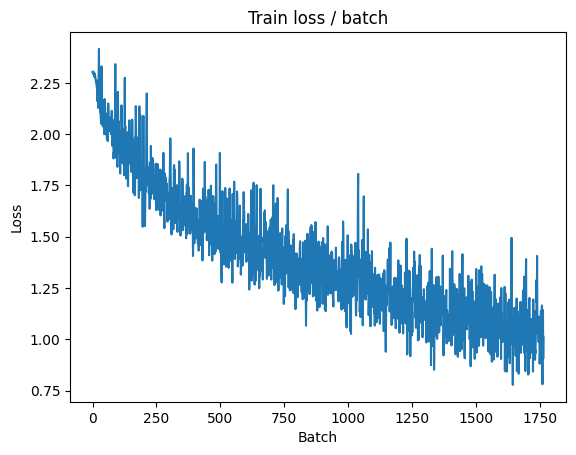


===============> Total time 16s	Avg loss 1.0311	Avg Prec@1 63.73 %	Avg Prec@5 96.45 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 0.8781 (0.8781)	Prec@1  71.9 ( 71.9)	Prec@5  99.2 ( 99.2)

===============> Total time 3s	Avg loss 0.9138	Avg Prec@1 67.76 %	Avg Prec@5 97.32 %



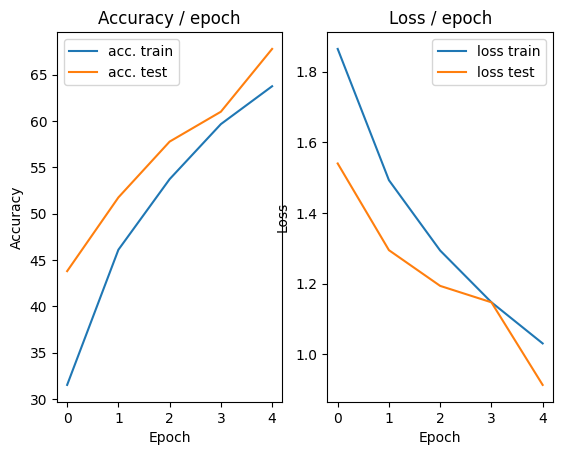

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.169s (0.169s)	Loss 0.9000 (0.9000)	Prec@1  68.8 ( 68.8)	Prec@5  98.4 ( 98.4)


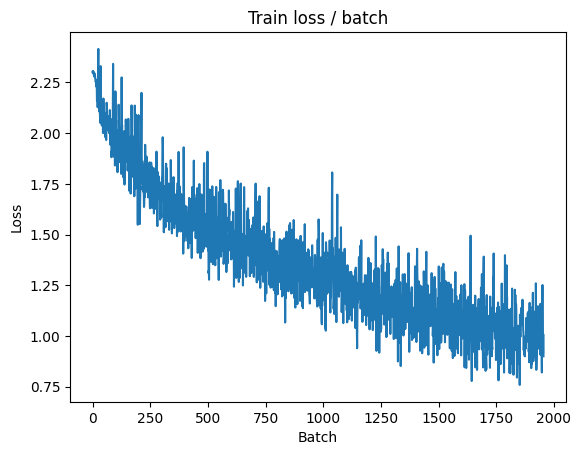

[TRAIN Batch 200/391]	Time 0.023s (0.040s)	Loss 0.9523 (0.9576)	Prec@1  61.7 ( 66.6)	Prec@5  96.9 ( 97.0)


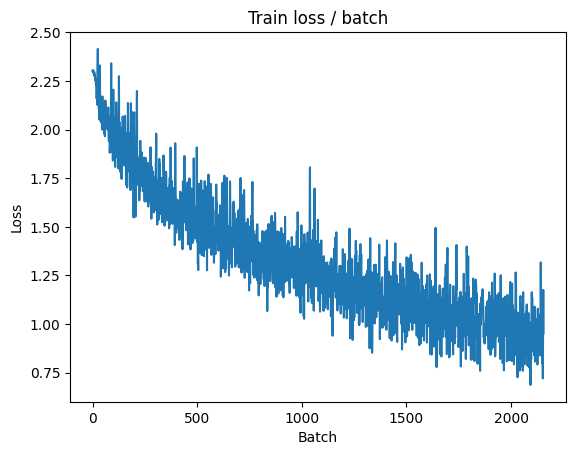


===============> Total time 16s	Avg loss 0.9452	Avg Prec@1 66.97 %	Avg Prec@5 97.05 %

[EVAL Batch 000/079]	Time 0.124s (0.124s)	Loss 0.8949 (0.8949)	Prec@1  63.3 ( 63.3)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.9426	Avg Prec@1 67.00 %	Avg Prec@5 97.53 %



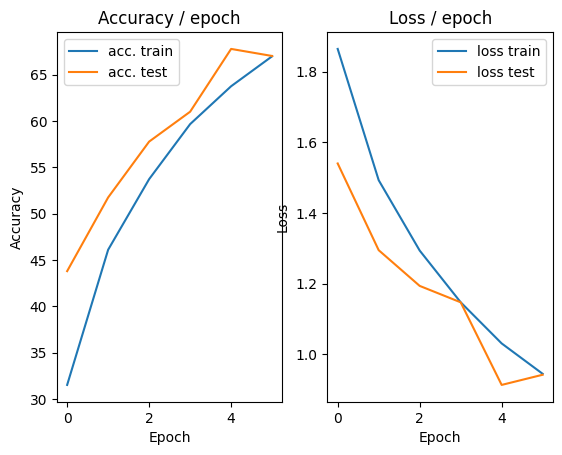

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.166s (0.166s)	Loss 1.0156 (1.0156)	Prec@1  66.4 ( 66.4)	Prec@5  96.1 ( 96.1)


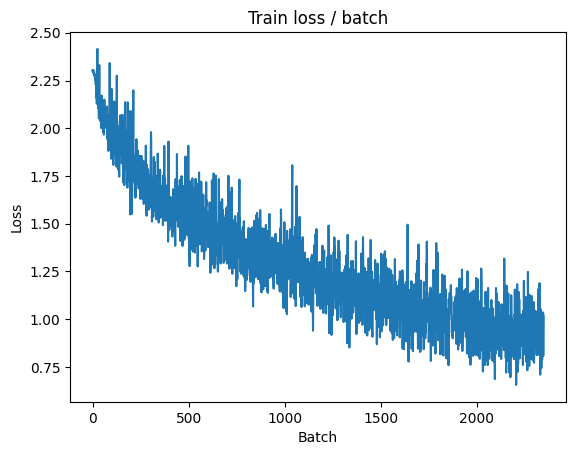

[TRAIN Batch 200/391]	Time 0.067s (0.045s)	Loss 0.7993 (0.8853)	Prec@1  73.4 ( 69.1)	Prec@5  98.4 ( 97.4)


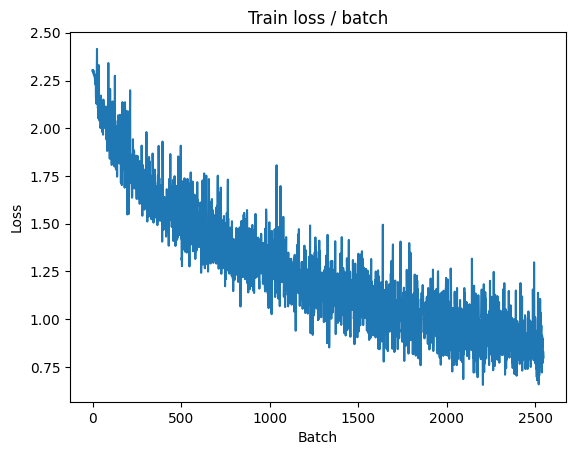


===============> Total time 17s	Avg loss 0.8742	Avg Prec@1 69.52 %	Avg Prec@5 97.41 %

[EVAL Batch 000/079]	Time 0.217s (0.217s)	Loss 0.7933 (0.7933)	Prec@1  73.4 ( 73.4)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.8046	Avg Prec@1 71.93 %	Avg Prec@5 98.02 %



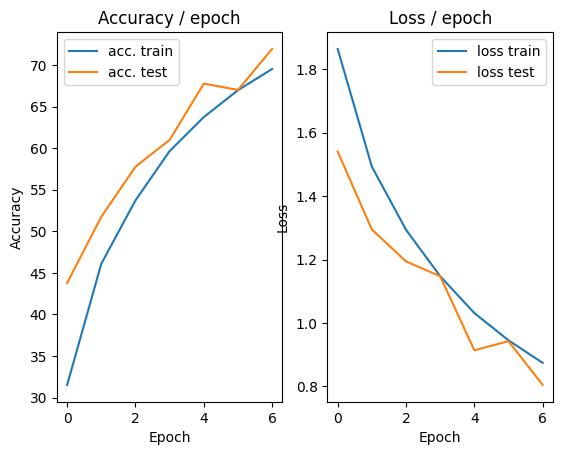

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.171s (0.171s)	Loss 0.8040 (0.8040)	Prec@1  73.4 ( 73.4)	Prec@5  99.2 ( 99.2)


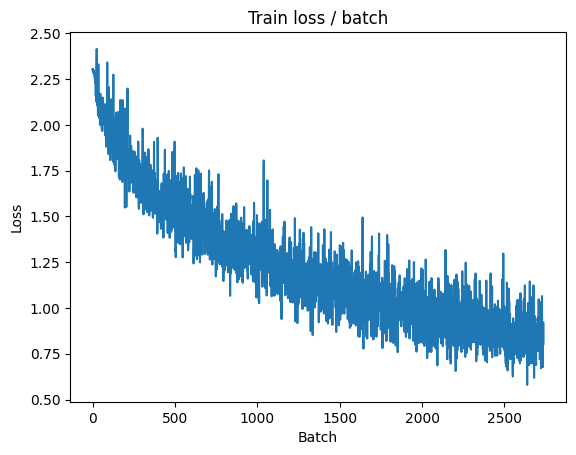

[TRAIN Batch 200/391]	Time 0.009s (0.041s)	Loss 0.7942 (0.8204)	Prec@1  73.4 ( 71.1)	Prec@5  98.4 ( 97.9)


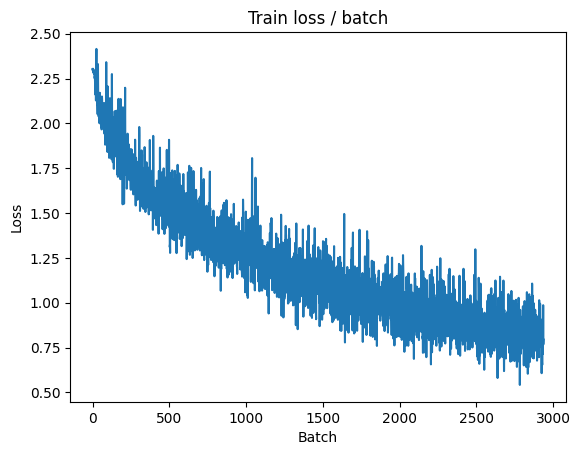


===============> Total time 17s	Avg loss 0.8175	Avg Prec@1 71.43 %	Avg Prec@5 97.88 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 0.9531 (0.9531)	Prec@1  70.3 ( 70.3)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.8943	Avg Prec@1 69.68 %	Avg Prec@5 96.79 %



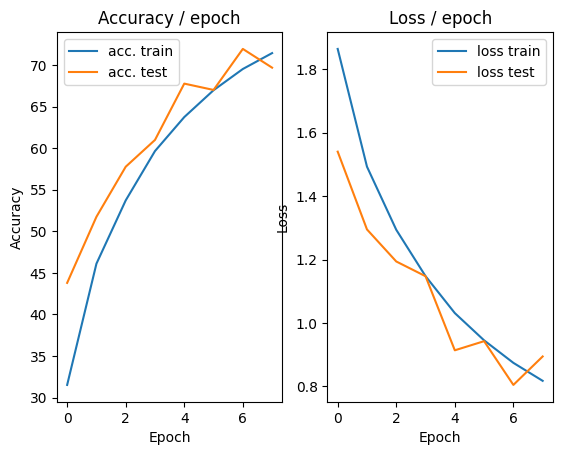

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.173s (0.173s)	Loss 1.0544 (1.0544)	Prec@1  65.6 ( 65.6)	Prec@5  94.5 ( 94.5)


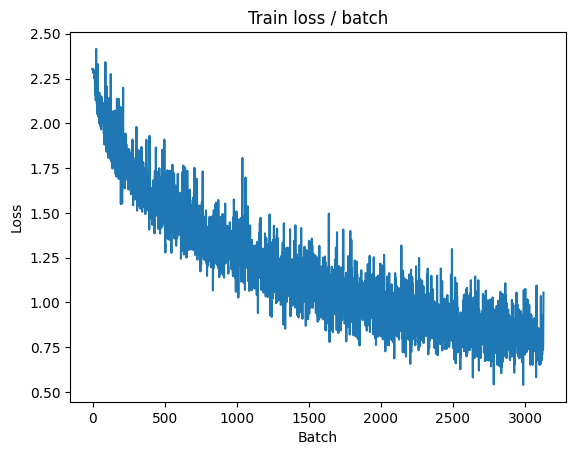

[TRAIN Batch 200/391]	Time 0.063s (0.046s)	Loss 0.8126 (0.7743)	Prec@1  72.7 ( 72.9)	Prec@5  94.5 ( 98.1)


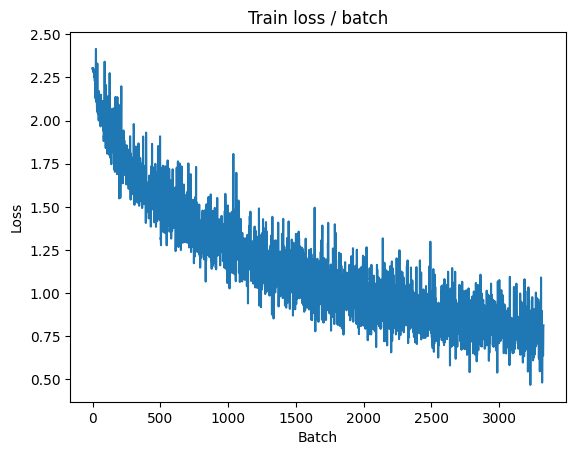


===============> Total time 17s	Avg loss 0.7669	Avg Prec@1 73.25 %	Avg Prec@5 98.08 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 0.7062 (0.7062)	Prec@1  75.8 ( 75.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.7791	Avg Prec@1 73.08 %	Avg Prec@5 98.15 %



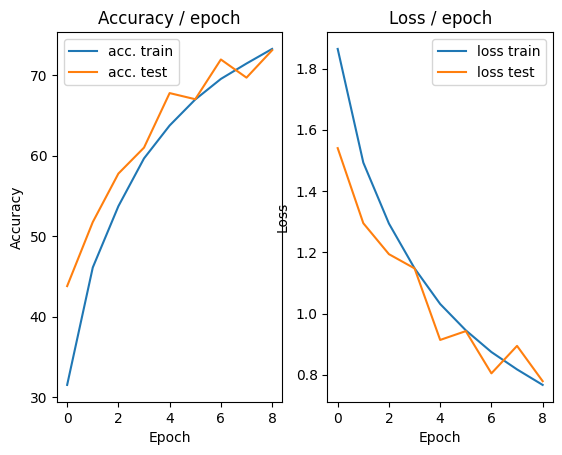

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.169s (0.169s)	Loss 0.7480 (0.7480)	Prec@1  76.6 ( 76.6)	Prec@5  96.1 ( 96.1)


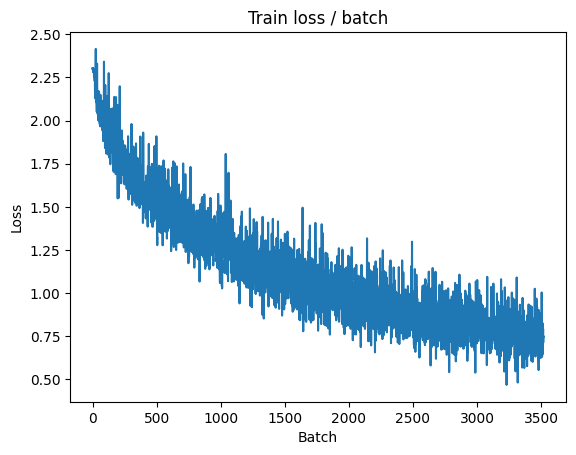

[TRAIN Batch 200/391]	Time 0.013s (0.044s)	Loss 0.7093 (0.7384)	Prec@1  73.4 ( 74.5)	Prec@5  98.4 ( 98.3)


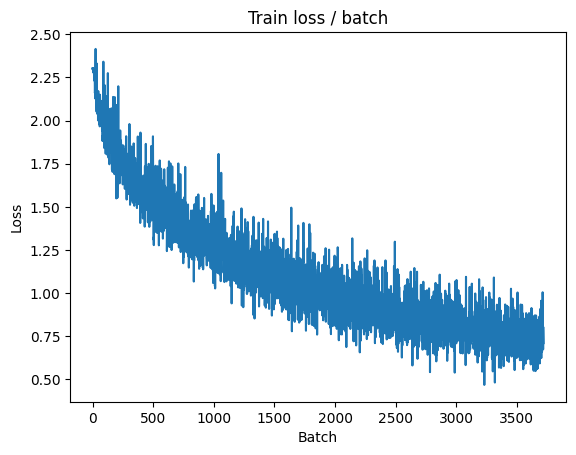


===============> Total time 16s	Avg loss 0.7320	Avg Prec@1 74.46 %	Avg Prec@5 98.25 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 0.7534 (0.7534)	Prec@1  76.6 ( 76.6)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7963	Avg Prec@1 72.16 %	Avg Prec@5 97.79 %



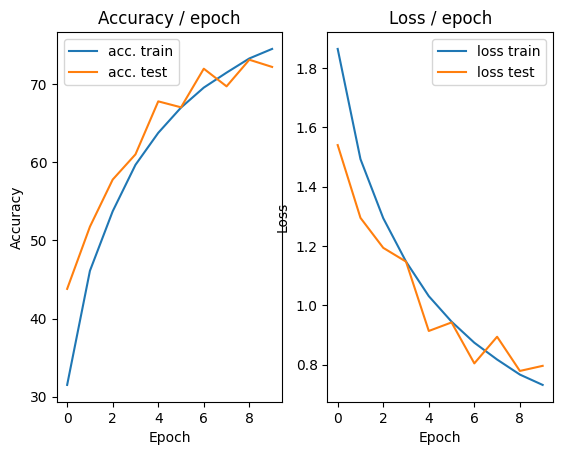

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.181s (0.181s)	Loss 1.0015 (1.0015)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)


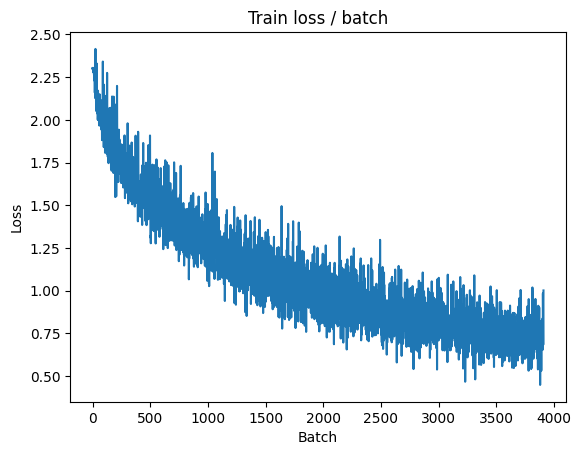

[TRAIN Batch 200/391]	Time 0.024s (0.045s)	Loss 0.6798 (0.7082)	Prec@1  76.6 ( 75.2)	Prec@5  98.4 ( 98.4)


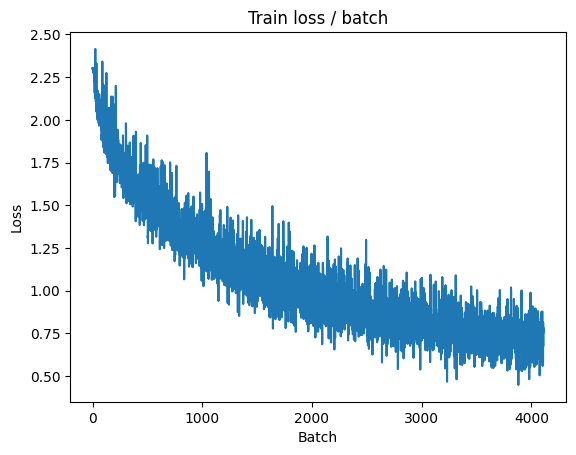


===============> Total time 17s	Avg loss 0.7038	Avg Prec@1 75.38 %	Avg Prec@5 98.41 %

[EVAL Batch 000/079]	Time 0.133s (0.133s)	Loss 0.6940 (0.6940)	Prec@1  79.7 ( 79.7)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7245	Avg Prec@1 74.84 %	Avg Prec@5 98.49 %



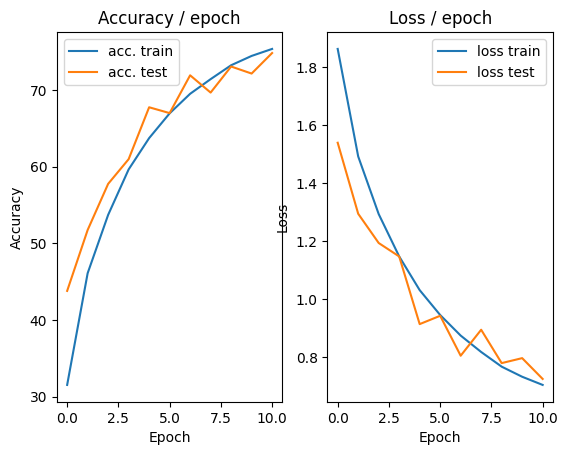

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.180s (0.180s)	Loss 0.7741 (0.7741)	Prec@1  70.3 ( 70.3)	Prec@5  99.2 ( 99.2)


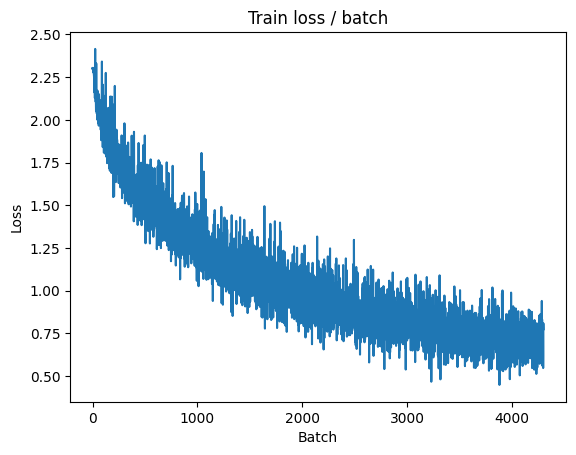

[TRAIN Batch 200/391]	Time 0.013s (0.045s)	Loss 0.4932 (0.6661)	Prec@1  86.7 ( 76.7)	Prec@5 100.0 ( 98.6)


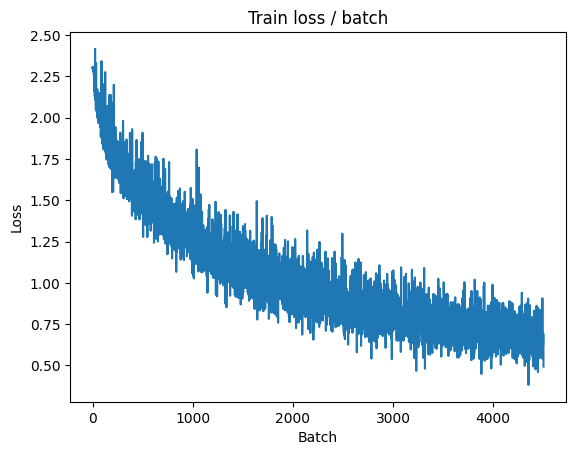


===============> Total time 16s	Avg loss 0.6688	Avg Prec@1 76.46 %	Avg Prec@5 98.61 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 0.6511 (0.6511)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6795	Avg Prec@1 75.98 %	Avg Prec@5 98.48 %



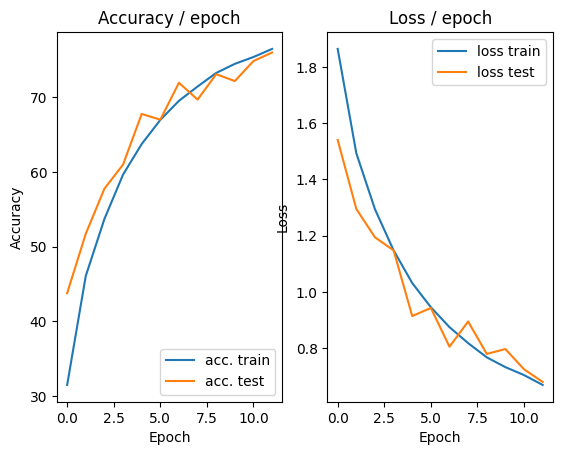

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.297s (0.297s)	Loss 0.7152 (0.7152)	Prec@1  78.1 ( 78.1)	Prec@5  97.7 ( 97.7)


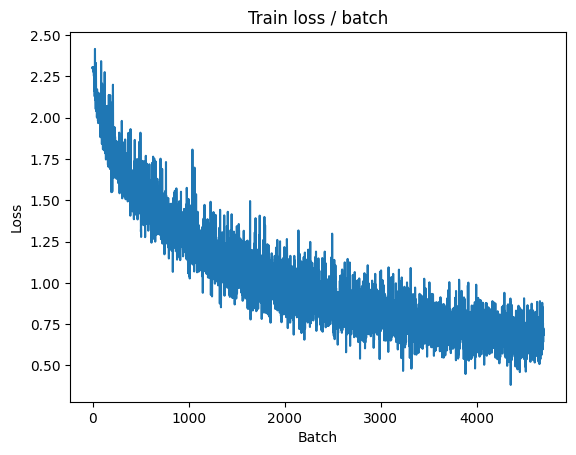

[TRAIN Batch 200/391]	Time 0.010s (0.044s)	Loss 0.8961 (0.6414)	Prec@1  71.9 ( 77.8)	Prec@5  99.2 ( 98.7)


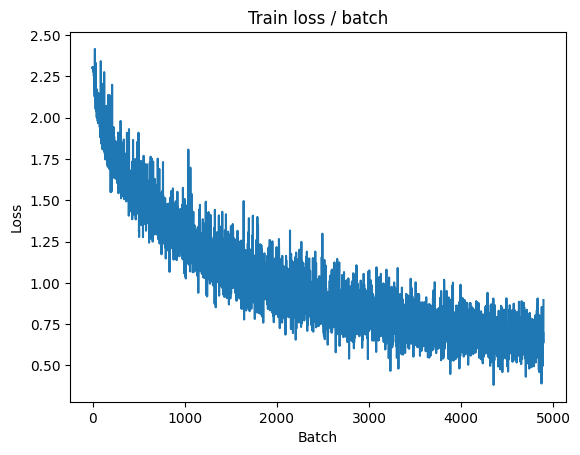


===============> Total time 17s	Avg loss 0.6410	Avg Prec@1 77.69 %	Avg Prec@5 98.68 %

[EVAL Batch 000/079]	Time 0.133s (0.133s)	Loss 0.6741 (0.6741)	Prec@1  78.9 ( 78.9)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.6980	Avg Prec@1 76.04 %	Avg Prec@5 98.40 %



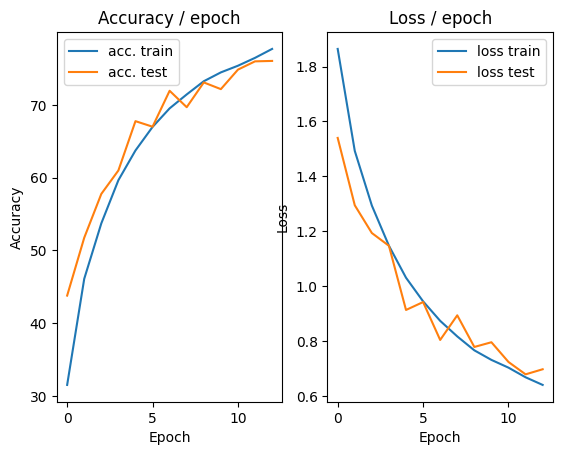

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.176s (0.176s)	Loss 0.6373 (0.6373)	Prec@1  80.5 ( 80.5)	Prec@5 100.0 (100.0)


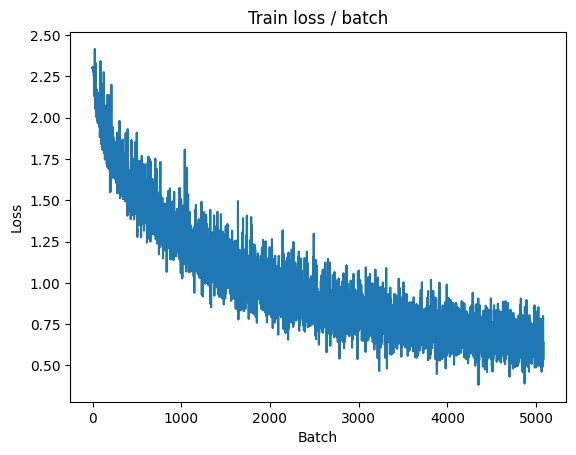

[TRAIN Batch 200/391]	Time 0.012s (0.046s)	Loss 0.6116 (0.6214)	Prec@1  80.5 ( 78.3)	Prec@5 100.0 ( 98.9)


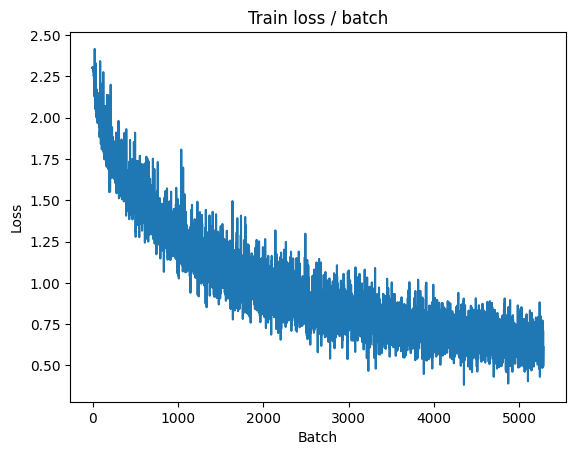


===============> Total time 16s	Avg loss 0.6230	Avg Prec@1 78.15 %	Avg Prec@5 98.82 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.6449 (0.6449)	Prec@1  81.2 ( 81.2)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 0.6356	Avg Prec@1 78.19 %	Avg Prec@5 98.72 %



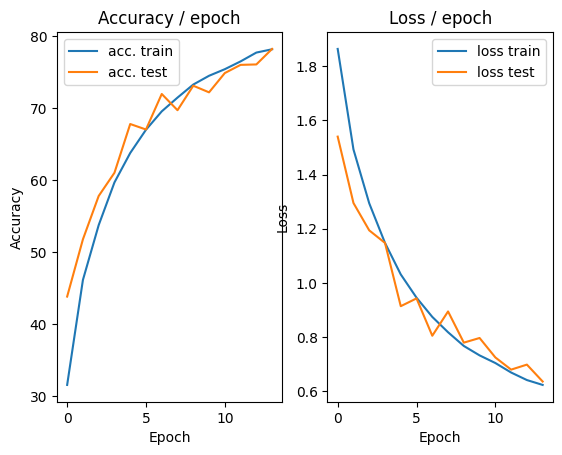

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.189s (0.189s)	Loss 0.7242 (0.7242)	Prec@1  75.0 ( 75.0)	Prec@5  98.4 ( 98.4)


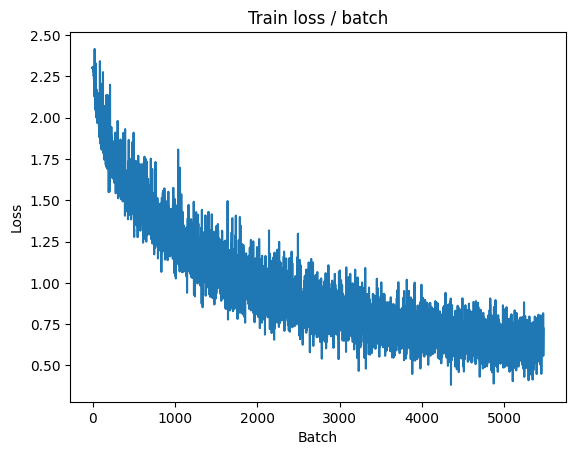

[TRAIN Batch 200/391]	Time 0.010s (0.041s)	Loss 0.7608 (0.5961)	Prec@1  71.9 ( 79.2)	Prec@5  98.4 ( 99.0)


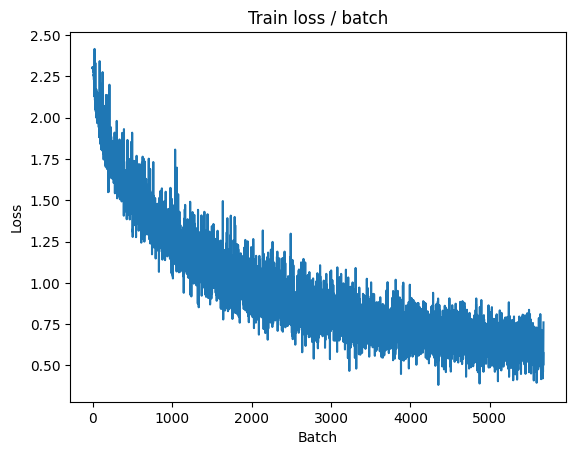


===============> Total time 16s	Avg loss 0.5971	Avg Prec@1 79.18 %	Avg Prec@5 98.92 %

[EVAL Batch 000/079]	Time 0.144s (0.144s)	Loss 0.5954 (0.5954)	Prec@1  78.1 ( 78.1)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6347	Avg Prec@1 77.84 %	Avg Prec@5 98.74 %



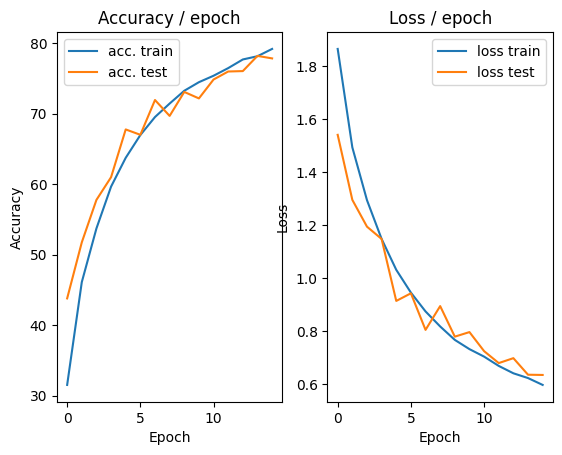

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.192s (0.192s)	Loss 0.5006 (0.5006)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)


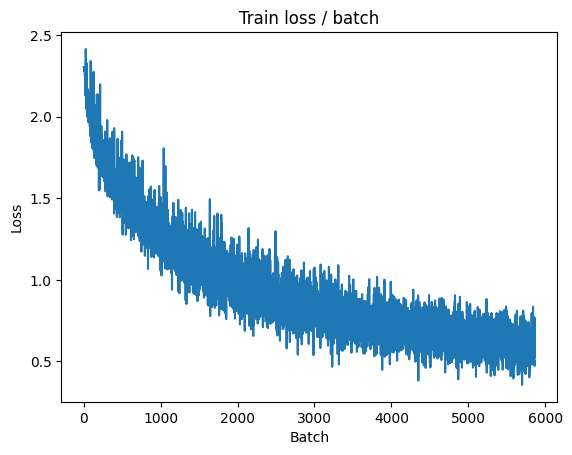

[TRAIN Batch 200/391]	Time 0.011s (0.045s)	Loss 0.5214 (0.5753)	Prec@1  81.2 ( 80.1)	Prec@5  99.2 ( 99.0)


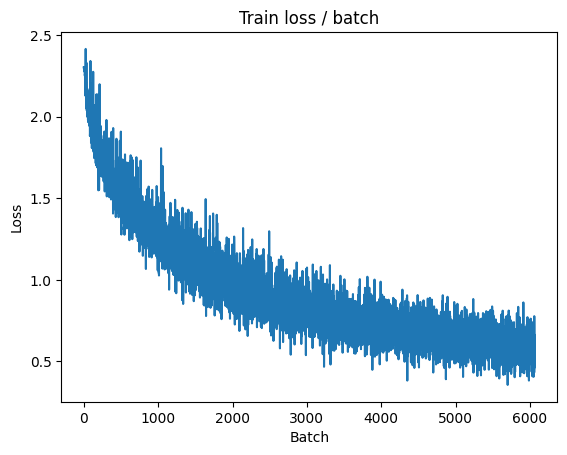


===============> Total time 17s	Avg loss 0.5764	Avg Prec@1 79.84 %	Avg Prec@5 98.96 %

[EVAL Batch 000/079]	Time 0.207s (0.207s)	Loss 0.5684 (0.5684)	Prec@1  80.5 ( 80.5)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6258	Avg Prec@1 78.48 %	Avg Prec@5 98.81 %



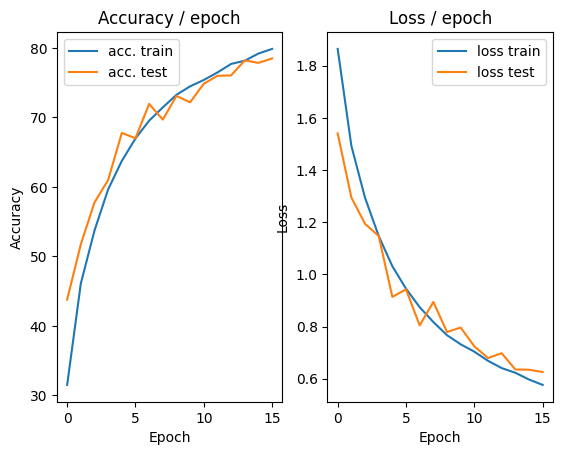

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.175s (0.175s)	Loss 0.5795 (0.5795)	Prec@1  82.0 ( 82.0)	Prec@5  99.2 ( 99.2)


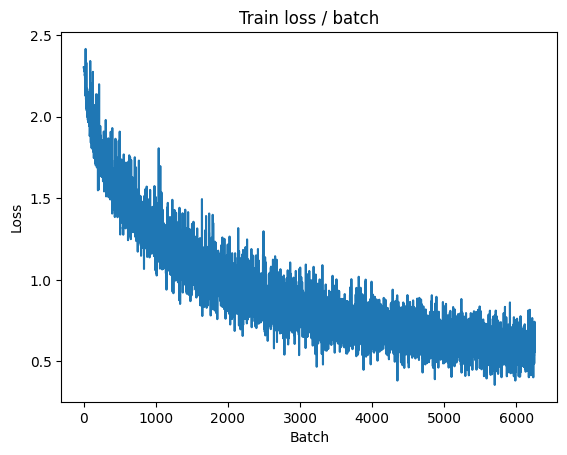

[TRAIN Batch 200/391]	Time 0.125s (0.042s)	Loss 0.5668 (0.5574)	Prec@1  79.7 ( 80.6)	Prec@5  99.2 ( 99.1)


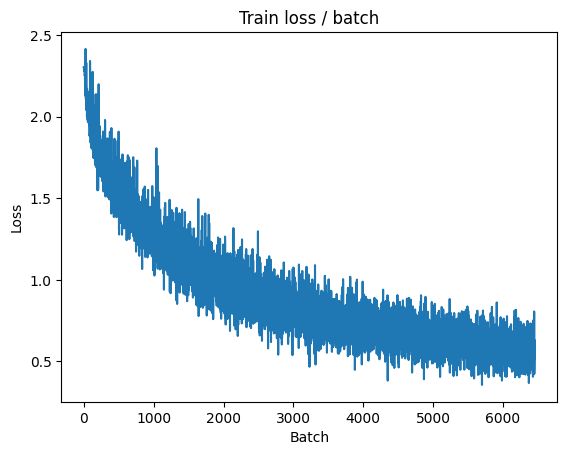


===============> Total time 16s	Avg loss 0.5560	Avg Prec@1 80.51 %	Avg Prec@5 99.10 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 0.5476 (0.5476)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5911	Avg Prec@1 79.51 %	Avg Prec@5 98.92 %



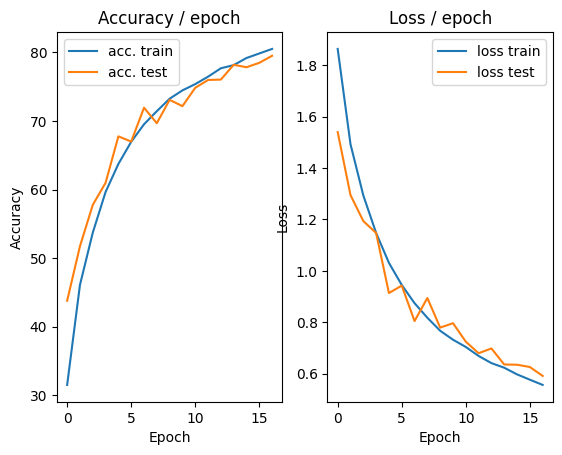

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.221s (0.221s)	Loss 0.5645 (0.5645)	Prec@1  78.1 ( 78.1)	Prec@5  99.2 ( 99.2)


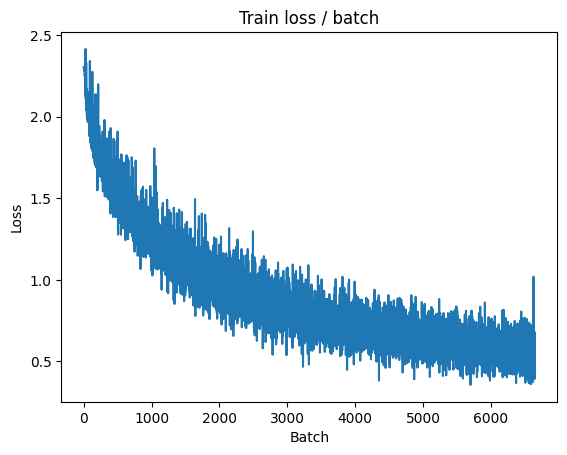

[TRAIN Batch 200/391]	Time 0.039s (0.045s)	Loss 0.4344 (0.5408)	Prec@1  82.0 ( 80.9)	Prec@5 100.0 ( 99.1)


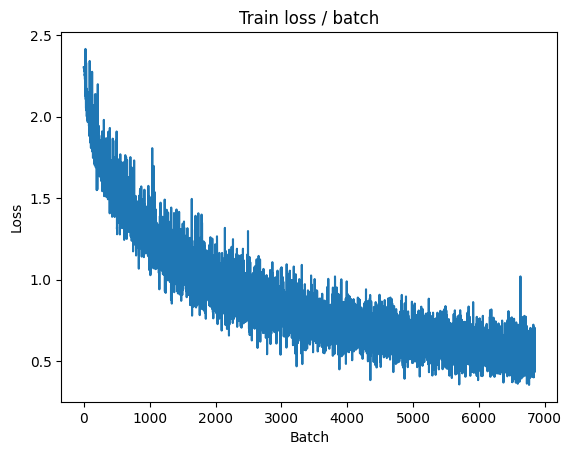


===============> Total time 17s	Avg loss 0.5397	Avg Prec@1 81.02 %	Avg Prec@5 99.12 %

[EVAL Batch 000/079]	Time 0.139s (0.139s)	Loss 0.6626 (0.6626)	Prec@1  79.7 ( 79.7)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6553	Avg Prec@1 77.96 %	Avg Prec@5 98.63 %



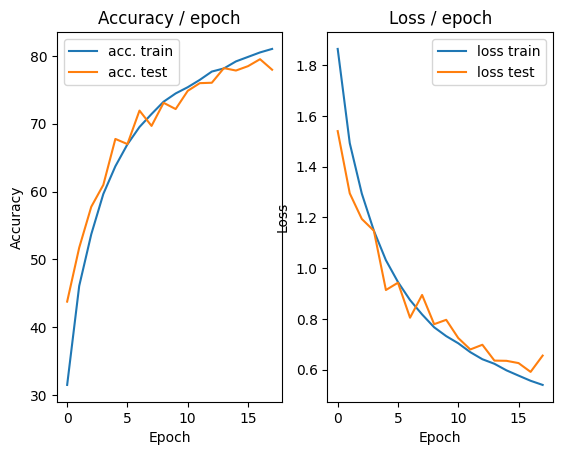

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.201s (0.201s)	Loss 0.7694 (0.7694)	Prec@1  77.3 ( 77.3)	Prec@5  97.7 ( 97.7)


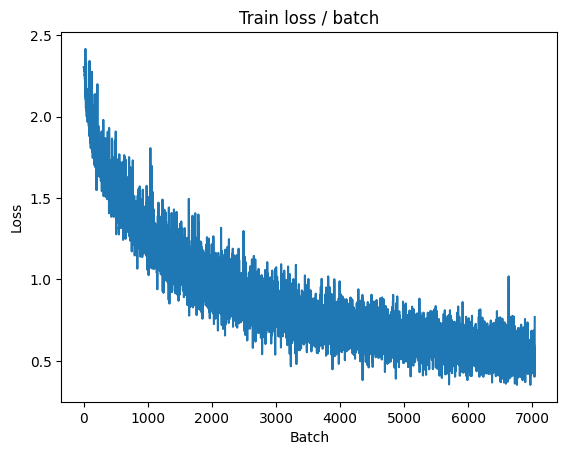

[TRAIN Batch 200/391]	Time 0.053s (0.047s)	Loss 0.5924 (0.5214)	Prec@1  78.1 ( 81.5)	Prec@5  99.2 ( 99.2)


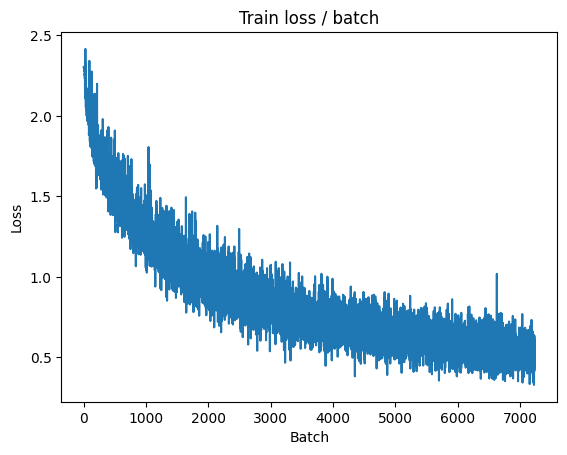


===============> Total time 16s	Avg loss 0.5236	Avg Prec@1 81.56 %	Avg Prec@5 99.19 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 0.5386 (0.5386)	Prec@1  82.8 ( 82.8)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.5969	Avg Prec@1 79.62 %	Avg Prec@5 98.86 %



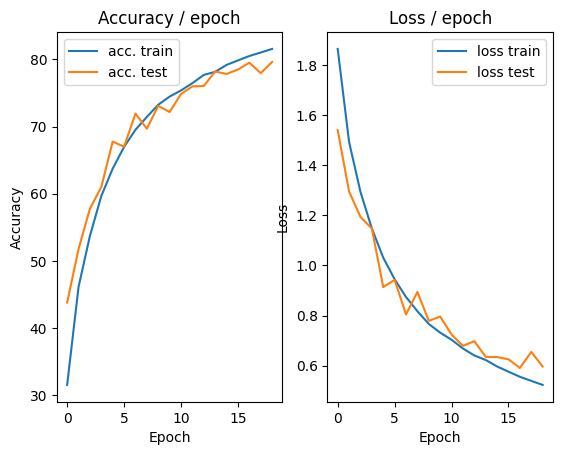

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.258s (0.258s)	Loss 0.4004 (0.4004)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


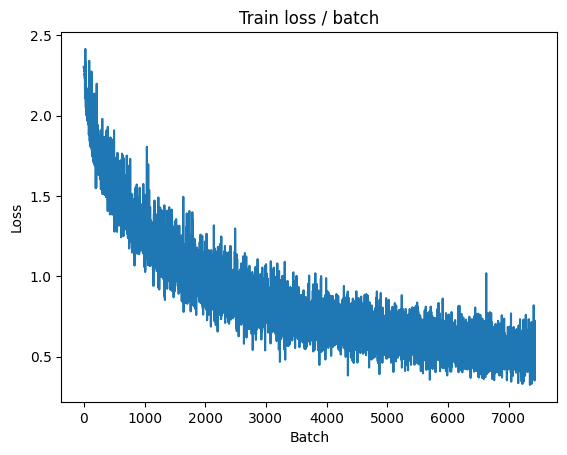

[TRAIN Batch 200/391]	Time 0.067s (0.043s)	Loss 0.5042 (0.5033)	Prec@1  84.4 ( 82.5)	Prec@5 100.0 ( 99.2)


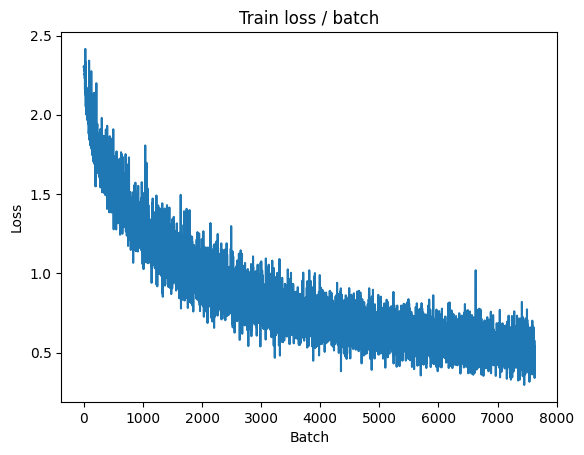


===============> Total time 17s	Avg loss 0.5108	Avg Prec@1 82.26 %	Avg Prec@5 99.21 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 0.6220 (0.6220)	Prec@1  80.5 ( 80.5)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5914	Avg Prec@1 79.78 %	Avg Prec@5 98.83 %



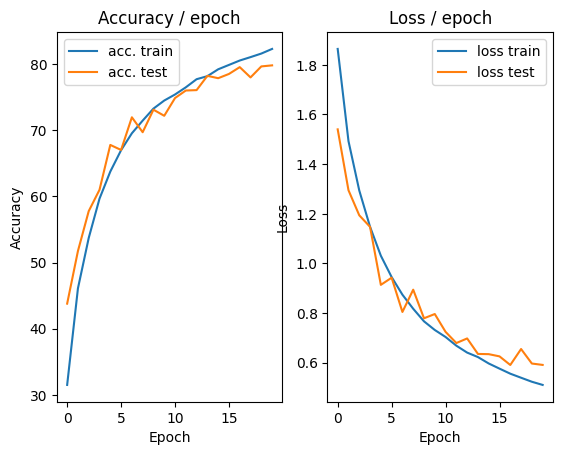

In [14]:
main(128, 0.1, 20, cuda=True)